In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
from scipy.optimize import minimize
from scipy.optimize import LinearConstraint, NonlinearConstraint

In [3]:
import pandas as pd

# Empirical Maresca-Curtin model for yield strength of BCC HEA

Model of the yield strength is taken from

```
Maresca, F., & Curtin, W. A. (2020). Mechanistic origin of high strength in refractory BCC high entropy alloys up to 1900K. Acta Materialia, 182, 235-249.
```

BiBTeX:
```latex
@article{maresca2020mechanistic,
  title={Mechanistic origin of high strength in refractory BCC high entropy alloys up to 1900K},
  author={Maresca, Francesco and Curtin, William A},
  journal={Acta Mater.},
  volume={182},
  pages={235--249},
  year={2020},
  publisher={Elsevier}
}
```

In [4]:
alpha=1/12

In [5]:
#input: a, c11, c12, c44, dV, c

def compute_tau0_dEb(a, C11, C12, C44, dV, comp):
    mu_bar = np.sqrt(1/2*C44*(C11-C12))
    print("mu = {:.0f} GPa".format(mu_bar))

    B_bar = (C11+2*C12)
    print("B = {:.0f} GPa".format(B_bar))

    nu_bar = (3*B_bar - 2*mu_bar)/2/(3*B_bar+mu_bar)
    print("nu = {:.2f}".format(nu_bar))

    b= a*np.sqrt(3)/2 # for BCC

    G = sum((comp*dV**2))/b**6

    tau_y0 = 0.040 * alpha**(-1/3) * mu_bar * ((1+nu_bar)/(1-nu_bar))**(4/3) * (G)**(2/3)
    print("tau_y0 = {:.3f} GPa".format(tau_y0)) # GPa

    dEb = 2.00 * alpha**(1/3) * mu_bar * b**3 * ((1+nu_bar)/(1-nu_bar))**(2/3) * (G)**(1/3)
    dEb_eV = dEb * 1e-21 * 6.242e18 # in eV
    print("dEb = {:.3f} eV".format(dEb_eV)) # GPa


# Model input parameters: experimental data and DFT data from Materials Project

list of elements from original paper

In [6]:
elements=["Mo","Nb","Ta","W"]

In [7]:
bcc_res=pd.read_json("MP_BCC_data.json", orient="records",)

In [8]:
bcc_res=bcc_res.set_index("pretty_formula")

Lattice constants are taken from Materials project dataset

In [9]:
volume_dict=bcc_res["volume"].to_dict()
a_dict=bcc_res["a_lattice"].to_dict()

Experimental data for elastic constants (in GPa) from NIST (URL: https://tsapps.nist.gov/publication/get_pdf.cfm?pub_id=851172 )

In [10]:
C11_dict={'Mo': 463.7, 
          'Nb': 240, 
          'Ta': 260, 
          'V': 228.2, 
          'W': 522}

C12_dict={'Mo': 158, 
          'Nb': 126, 
          'Ta': 154, 
          'V': 119, 
          'W': 204}

C44_dict={'Mo': 109, 
          'Nb': 28, 
          'Ta': 83, 
          'V': 43, 
          'W': 161}

In [11]:
a_array=np.array([a_dict[el] for el in elements])
volume_array=np.array([volume_dict[el] for el in elements])
C11_array=np.array([C11_dict[el] for el in elements])
C12_array=np.array([C12_dict[el] for el in elements])
C44_array=np.array([C44_dict[el] for el in elements])

In [12]:
def compute_tau0_dEb(a, C11, C12, C44, dV, comp):
    mu_bar = np.sqrt(1/2*C44*(C11-C12))
    B_bar = (C11+2*C12)
    nu_bar = (3*B_bar - 2*mu_bar)/2/(3*B_bar+mu_bar)
    b= a*np.sqrt(3)/2 # for BCC

    G = sum((comp*dV**2))/b**6

    tau_y0 = 0.040 * alpha**(-1/3) * mu_bar * ((1+nu_bar)/(1-nu_bar))**(4/3) * (G)**(2/3)
    dEb = 2.00 * alpha**(1/3) * mu_bar * b**3 * ((1+nu_bar)/(1-nu_bar))**(2/3) * (G)**(1/3)
    dEb_eV = dEb * 1e-21 * 6.242e18 # in eV
    return tau_y0, dEb_eV

In [13]:
M= 3.067
eps_dot_0=1e4
eps_dot=1e-4

def calc_sigma_compLT(comp, a_a=a_array, 
                    volume_a=volume_array, 
                    C11_a=C11_array, 
                    C12_a=C12_array, 
                    C44_a=C44_array, T=300, verbose=False):
    a = np.sum(a_a*comp)
    V = np.sum(volume_a*comp)
    C11 = np.sum(C11_a*comp)
    C12 = np.sum(C12_a*comp)
    C44 = np.sum(C44_a*comp)
    dV = volume_a-V
    if verbose:
        print("a:",a)
        print("dV:", dV)
        print("C11, C12, C44:", C11, C12, C44)
    
    b=a*np.sqrt(3)/2 # bcc Burger's vector
    
    tau_y0, dEb_eV =  compute_tau0_dEb(a = a, comp=comp,dV=dV, C11=C11, C12=C12, C44=C44)
    kT_eV = 1.38*1e-23 * T  * 6.242e18    
    tau_y = tau_y0*(1 - (kT_eV/dEb_eV*np.log(eps_dot_0/eps_dot))**(2/3))
    if verbose:
        print("tau_y0 =  {:.3f}, tau_y = {:.3f}, tau_y/tau_y0={:.2f}".format(tau_y,tau_y0, tau_y/tau_y0))  
        if tau_y/tau_y0 <0.5:
            print("WARNING, tau_y/tau_y0<0.5 (not low-T regime)")
    sigma_y = tau_y * M
    return sigma_y # GPa

In [14]:
def calc_sigma_compHT(comp, a_a=a_array, 
                    volume_a=volume_array, 
                    C11_a=C11_array, 
                    C12_a=C12_array, 
                    C44_a=C44_array, T=300, verbose=False):
    a = np.sum(a_a*comp)
    V = np.sum(volume_a*comp)
    C11 = np.sum(C11_a*comp)
    C12 = np.sum(C12_a*comp)
    C44 = np.sum(C44_a*comp)
    dV = volume_a-V
    if verbose:
        print("a:",a)
        print("dV:", dV)
        print("C11, C12, C44:", C11, C12, C44)
    
    b=a*np.sqrt(3)/2 # bcc Burger's vector
    
    tau_y0, dEb_eV =  compute_tau0_dEb(a = a, comp=comp,dV=dV, C11=C11, C12=C12, C44=C44)
    kT_eV = 1.38*1e-23 * T  * 6.242e18    
    tau_y = tau_y0*np.exp(-1/0.55*kT_eV/dEb_eV*np.log(eps_dot_0/eps_dot))
    if verbose:
        print("tau_y0 =  {:.3f}, tau_y = {:.3f}, tau_y/tau_y0={:.2f}".format(tau_y,tau_y0, tau_y/tau_y0))        
        if tau_y/tau_y0 >=0.5:
            print("WARNING, tau_y/tau_y0>0.5 (not high-T regime)")
    sigma_y = tau_y * M
    return sigma_y # GPa

In [16]:
def calc_sigma_comp(comp, a_a=a_array, 
                    volume_a=volume_array, 
                    C11_a=C11_array, 
                    C12_a=C12_array, 
                    C44_a=C44_array, T=300, verbose=False):
    a = np.sum(a_a*comp)
    V = np.sum(volume_a*comp)
    C11 = np.sum(C11_a*comp)
    C12 = np.sum(C12_a*comp)
    C44 = np.sum(C44_a*comp)
    dV = volume_a-V
    if verbose:
        print("a:",a)
        print("dV:", dV)
        print("C11, C12, C44:", C11, C12, C44)
    
    b=a*np.sqrt(3)/2 # bcc Burger's vector
    
    tau_y0, dEb_eV =  compute_tau0_dEb(a = a, comp=comp,dV=dV, C11=C11, C12=C12, C44=C44)
    kT_eV = 1.38*1e-23 * T  * 6.242e18    
    tau_y = tau_y0*(1 - (kT_eV/dEb_eV*np.log(eps_dot_0/eps_dot))**(2/3)) # low T model
    if tau_y/tau_y0 <0.5:
        # use high-T model
        tau_y = tau_y0*np.exp(-1/0.55*kT_eV/dEb_eV*np.log(eps_dot_0/eps_dot)) # high T model
    
    
    sigma_y = tau_y * M
    return sigma_y # GPa

In [17]:
def inv_calc_sigma_comp(comp,T=300):
    return -calc_sigma_comp(comp,T=T)

In [18]:
def inv_calc_sigma_compLT(comp,T=300):
    return -calc_sigma_compLT(comp,T=T)

In [19]:
def inv_calc_sigma_compHT(comp,T=300):
    return -calc_sigma_compHT(comp,T=T)

In [20]:
def comp_to_str(comp, sep=" ", latex_style=False):
    if not latex_style:
        return sep.join(["{}_{:.3f}".format(el,c) for el,c in zip(elements,comp) if c>1e-3])
    else:
        return sep.join(["{}$_{{{:.1f}}}$".format(el,100*c) for el,c in zip(elements,comp) if c>1e-3])

In [21]:
def print_composition(comp, sep=" ", latex_style=False):
    print(comp_to_str(comp,sep=sep, latex_style=latex_style))

In [22]:
def sigmoid(x):
    return np.sum((np.tanh((x-0.05)*50)+1)/2)

In [23]:
def maximize_yield_strength(initialcomp=None, n_elements=None, T=300, model="LT"):
    """
    model: LT, HT, auto
    """
    if initialcomp is None:
        # initial composition is equicomposition
        initialcomp = np.ones(len(elements))/len(elements)
    
    # list of optimization contraints
    constraints = []
    
    # valid bounds for elements concentration
    bounds=[[0.0, 1]]*len(elements)
    
    # normalization contraint - sum of concentrations equals to one
    lc=LinearConstraint(A=np.ones_like(elements,dtype=np.float64).reshape(1,-1),lb = 1, ub=1)
    constraints.append(lc)
    
    if n_elements is not None:
        nlc=NonlinearConstraint(sigmoid,n_elements-0.05,n_elements+0.05)
        constraints.append(nlc)
    
    if model=="LT":
        opt_func = inv_calc_sigma_compLT
    elif model=="HT":
        opt_func = inv_calc_sigma_compHT
    elif model=="auto":
        opt_func = inv_calc_sigma_comp
    else:
        raise ValueError("Unknown model='{}'. Must be LT/HT/auto".format(model))
    print("Model used:",model)
    min_res=minimize(opt_func,
                     x0=equicomp, 
                     args=(T),
                     bounds=bounds, 
                     constraints=constraints, 
                     method='trust-constr')
    return min_res


# Yield strength

## Equicomposition

In [24]:
elements

['Mo', 'Nb', 'Ta', 'W']

In [25]:
Tlow  = 300
Thigh = 1300

In [26]:
n_elements=len(elements)

In [27]:
equicomp=np.ones_like(elements,dtype="f")/n_elements

In [28]:
print("T = ", Tlow, "K")
print("Equicomposition:", comp_to_str(equicomp))
print("Yield Strength: {:.2f} GPa".format(calc_sigma_comp(comp=equicomp,T=Tlow, verbose=True)))

T =  300 K
Equicomposition: Mo_0.250 Nb_0.250 Ta_0.250 W_0.250
a: 3.24946
dV: [-1.28934348  1.12481059  1.15406672 -0.98953383]
C11, C12, C44: 371.425 160.5 95.25
Yield Strength: 1.31 GPa


In [29]:
print("T = ", Tlow, "K")
print("Equicomposition:", comp_to_str(equicomp))
print("Yield Strength: {:.2f} GPa".format(calc_sigma_compHT(comp=equicomp,T=Tlow, verbose=True)))

T =  300 K
Equicomposition: Mo_0.250 Nb_0.250 Ta_0.250 W_0.250
a: 3.24946
dV: [-1.28934348  1.12481059  1.15406672 -0.98953383]
C11, C12, C44: 371.425 160.5 95.25
tau_y0 =  0.454, tau_y = 0.599, tau_y/tau_y0=0.76
WARNING, tau_y/tau_y0>0.5 (not high-T regime)
Yield Strength: 1.39 GPa


## Yield strength constrained optimization at low (300K) and high (1300K) temperatures

In [30]:
lowT_ternary_opt = maximize_yield_strength(T=Tlow)

Model used: LT


In [31]:
print("T = ", Tlow, "K")
print("Maximal YS composition:", comp_to_str(lowT_ternary_opt.x))
print("Yield Strength: {:.2f} GPa".format(-lowT_ternary_opt.fun))
print("Yield Strength: {:.2f} GPa".format(calc_sigma_comp(comp=lowT_ternary_opt.x,T=Tlow, verbose=True)))

T =  300 K
Maximal YS composition: Mo_0.403 Ta_0.360 W_0.238
Yield Strength: 1.53 GPa
a: 3.227960931572001
dV: [-0.95020025  1.46395382  1.49320995 -0.6503906 ]
C11, C12, C44: 404.28738141928443 167.4973922666703 112.01014856494183
Yield Strength: 1.53 GPa


In [32]:
highT_ternary_opt= maximize_yield_strength(T=Thigh)

Model used: LT


In [33]:
print("T = ", Thigh, "K")
print("Maximal YS composition:", comp_to_str(highT_ternary_opt.x))
print()
print("Yield Strength: {:.2f} GPa".format(calc_sigma_comp(comp=highT_ternary_opt.x,T=Thigh, verbose=True)))

T =  1300 K
Maximal YS composition: Mo_0.120 Ta_0.333 W_0.547

a: 3.22993371901502
dV: [-0.97737423  1.43677983  1.46603597 -0.67756459]
C11, C12, C44: 427.75526638007454 181.81601607956924 128.77179410251512
Yield Strength: 0.72 GPa


### Optimize using highT model

In [34]:
highT_ternary_opt2= maximize_yield_strength(T=Thigh, model='HT')

Model used: HT


In [35]:
print("T = ", Thigh, "K")
print("Maximal YS composition:", comp_to_str(highT_ternary_opt2.x))
print("Yield StrengthHT: {:.2f} GPa".format(calc_sigma_compHT(comp=highT_ternary_opt2.x,T=Thigh, verbose=True)))

T =  1300 K
Maximal YS composition: Mo_0.185 Ta_0.339 W_0.476
a: 3.229480331223664
dV: [-0.97112092  1.44303315  1.47228928 -0.67131127]
C11, C12, C44: 422.41509916718803 178.55460653998873 124.95442339101541
tau_y0 =  0.235, tau_y = 0.669, tau_y/tau_y0=0.35
Yield StrengthHT: 0.72 GPa


## Nonlinear constraint with number of elements

In [38]:
lowT_quaternary_opt=maximize_yield_strength(n_elements=4, T=Tlow)

Model used: LT


In [39]:
print("T = ", Tlow, "K")
print("Maximal YS composition (4 elements):", comp_to_str(lowT_quaternary_opt.x))
print("Yield Strength: {:.2f} GPa".format(-lowT_quaternary_opt.fun))

T =  300 K
Maximal YS composition (4 elements): Mo_0.375 Nb_0.079 Ta_0.279 W_0.267
Yield Strength: 1.50 GPa


In [40]:
highT_quaternary_opt = maximize_yield_strength(n_elements=4, T=Thigh)

Model used: LT


In [41]:
print("T = ", Thigh, "K")
print("Maximal YS composition (4 elements):", comp_to_str(highT_quaternary_opt.x))
print("Yield StrengthHT: {:.2f} GPa".format(calc_sigma_comp(comp=highT_quaternary_opt.x,
                                                              T=Thigh, verbose=True)))

T =  1300 K
Maximal YS composition (4 elements): Mo_0.117 Nb_0.080 Ta_0.253 W_0.551
a: 3.229789649435075
dV: [-0.97493609  1.43921797  1.46847411 -0.67512645]
C11, C12, C44: 426.5339349299729 179.78737545784264 124.62977705202965
Yield StrengthHT: 0.69 GPa


### Optimize using highT model

In [42]:
highT_quaternary_opt2 = maximize_yield_strength(n_elements=4, T=Thigh, model="HT")

Model used: HT


In [43]:
print("T = ", Thigh, "K")
print("Maximal YS composition (4 elements):", comp_to_str(highT_quaternary_opt2.x))
print("Yield StrengthHT: {:.2f} GPa".format(calc_sigma_compHT(comp=highT_quaternary_opt2.x,
                                                              T=Thigh, verbose=True)))

T =  1300 K
Maximal YS composition (4 elements): Mo_0.160 Nb_0.079 Ta_0.259 W_0.502
a: 3.229742182040468
dV: [-0.97482474  1.43932932  1.46858546 -0.6750151 ]
C11, C12, C44: 422.4346673800066 177.4984965414618 121.91942781977774
tau_y0 =  0.226, tau_y = 0.655, tau_y/tau_y0=0.35
Yield StrengthHT: 0.69 GPa


# Plot temperature dependencies

In [45]:
Ts = np.linspace(200, 1900)

In [46]:
equicomp_sigmas = [calc_sigma_comp(equicomp, T=T) for T in Ts]
equicomp_sigmasLT = [calc_sigma_compLT(equicomp, T=T) for T in Ts]
equicomp_sigmasHT = [calc_sigma_compHT(equicomp, T=T) for T in Ts]

Switch between low-T and high-T models for equiatomic composition

Text(0, 0.5, 'Yield stress (GPa)')

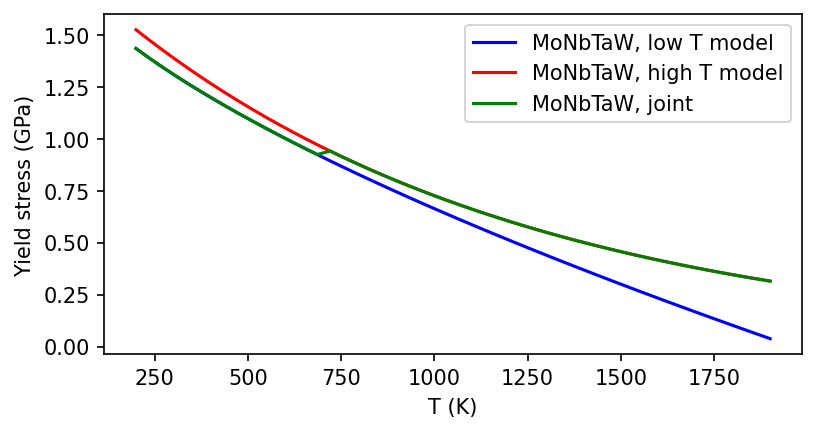

In [49]:
plt.figure(figsize=(6,3), dpi=150)
plt.plot(Ts, equicomp_sigmasLT, label="MoNbTaW, low T model", alpha=1, color="blue")
plt.plot(Ts, equicomp_sigmasHT, label="MoNbTaW, high T model", alpha=1, color="red")
plt.plot(Ts, equicomp_sigmas, label="MoNbTaW, joint", alpha=1, color="green")
plt.legend()
plt.xlabel("T (K)")
plt.ylabel("Yield stress (GPa)")

In [50]:
ternary_comp=comp_to_str(lowT_ternary_opt.x, sep="", latex_style=True)
quaternary_comp=comp_to_str(lowT_quaternary_opt.x, sep="", latex_style=True)

In [51]:
ternary_HT_comp=comp_to_str(highT_ternary_opt.x, sep="", latex_style=True)
quaternary_HT_comp=comp_to_str(highT_quaternary_opt.x, sep="", latex_style=True)

In [52]:
ternary_HT_comp2=comp_to_str(highT_ternary_opt2.x, sep="", latex_style=True)
quaternary_HT_comp2=comp_to_str(highT_quaternary_opt2.x, sep="", latex_style=True)

In [53]:
lowT_ternary_sigmas = [calc_sigma_comp(lowT_ternary_opt.x, T=T) for T in Ts]

In [54]:
lowT_quaternary_sigmas = [calc_sigma_comp(lowT_quaternary_opt.x, T=T) for T in Ts]

In [55]:
highT_ternary_sigmas = [calc_sigma_comp(highT_ternary_opt.x, T=T) for T in Ts]

In [56]:
highT_quaternary_sigmas = [calc_sigma_comp(highT_quaternary_opt.x, T=T) for T in Ts]

In [57]:
highT_ternary_sigmas2 = [calc_sigma_comp(highT_ternary_opt2.x, T=T) for T in Ts]
highT_quaternary_sigmas2 = [calc_sigma_comp(highT_quaternary_opt2.x, T=T) for T in Ts]

In [58]:
ternary_comp='Mo$_{40.2}$Ta$_{36.0}$W$_{23.8}$'

In [59]:
quaternary_HT_comp='Mo$_{11.7}$Nb$_{8.0}$Ta$_{25.3}$W$_{55.0}$'

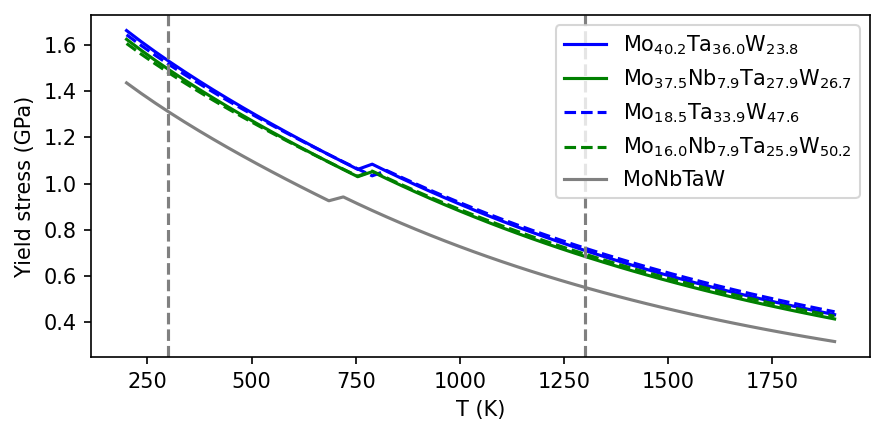

In [60]:
plt.figure(figsize=(6,3), dpi=150)

plt.plot(Ts,lowT_ternary_sigmas, color="blue", label=ternary_comp)
plt.plot(Ts,lowT_quaternary_sigmas, color="green",  label=quaternary_comp)

plt.plot(Ts,highT_ternary_sigmas2, color="blue", ls="--",label=ternary_HT_comp2)
plt.plot(Ts,highT_quaternary_sigmas2, color="green", ls="--", label=quaternary_HT_comp2)

plt.plot(Ts,equicomp_sigmas, color="gray", label="MoNbTaW")
plt.axvline(Tlow, color="gray", ls="--")
plt.axvline(Thigh, color="gray", ls="--")
plt.xlabel("T (K)")
plt.ylabel("Yield stress (GPa)")
plt.legend()
plt.tight_layout()
plt.savefig("YS_T_HT_new.pdf")